# Image-to-Image Translation via CycleGAN
Author: Jin Yeom (jinyeom@utexas.edu)  
Paper Authors: Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros
<img src="images/cyclegan.jpg" width=50% align="right"/>
## Contents
- [Configuration](#Configuration)
- [Datasets](#Datasets)
- [Model](#Model)
- [Training](#Training)
- [Experiments](#Experiments)
- [Results](#Results)
- [References](#References)

In [1]:
import os
import zipfile
import pathlib
import itertools
from glob import glob
from PIL import Image
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import wget
from tqdm import tqdm_notebook as tqdm
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

## Configuration

In [2]:
# name of the dataset to work with
DATASET_NAME = "horse2zebra"
# number of epoch of training
N_EPOCH = 200
# batch size for training
BATCH_SIZE = 4
# initial learning rate for Adam optimizer
ALPHA = 0.0002
# first order gradient momentum decay rate
BETA_1 = 0.5
# second order gradient momentum decay rate
BETA_2 = 0.999
# epoch from which alpha starts decay
EPOCH_DECAY = 100
# number of CPUs for batch generation
N_CPU = 4
# image width
WIDTH = 128 # TODO: use this to determine number of residual blocks
# image height
HEIGHT = 128 # TODO: use this to determine number of residual blocks
# image channels
CHANNELS = 3
# interval between sampling from generator
SAMPLE_INTERVAL = 100
# interval between model saving checkpoints
CHECKPOINT_INTERVAL = 100
# lambda parameter for cycle-consistency loss
LAMBDA = 10.0

## Datasets

### Download

In [ ]:
def download_dataset(name):
    if name not in {"ae_photos", "apple2orange", "summer2winter_yosemite", "horse2zebra", 
                    "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", 
                    "cityscapes", "facades", "iphone2dslr_flower", "ae_photos"}:
        raise ValueError("invalid argument dataset name")
        
    try:
        # mkdir datasets/cyclegan if it doesn't exist yet
        pathlib.Path("./datasets/cyclegan").mkdir(parents=True)
    except FileExistsError:
        pass
        
    # download the dataset
    print(f"downloading {name}...", end="", flush=True)
    zip_path = f"./datasets/cyclegan/{name}.zip"
    target_dir = f"./datasets/cyclegan/{name}/"
    url = f"https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{name}.zip"
    wget.download(url, out=zip_path)
    
    try:
        #mkdir dataset directory and unzip if it doesn't exist
        pathlib.Path(target_dir).mkdir(parents=True)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall("datasets/cyclegan/")
    except FileExistsError:
        pass
    os.remove(zip_path)
    print("done")

In [ ]:
# NOTE: only download if you have to!
download_dataset("apple2orange")
download_dataset("horse2zebra")

In [ ]:
!ls ./datasets/cyclegan

In [ ]:
!ls ./datasets/cyclegan/horse2zebra/

### Loaders

In [3]:
class ABImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.transform = transform
        self.unaligned = unaligned
        self.A = sorted(glob(os.path.join(root, f"{mode}A") + "/*.*"))
        self.B = sorted(glob(os.path.join(root, f"{mode}B") + "/*.*"))
        
    def __len__(self):
        return max(len(self.A), len(self.B))
        
    def __getitem__(self, index):
        a = self.A[index % len(self.A)]
        b = (self.B[np.random.randint(0, len(self.B) - 1)] if self.unaligned
             else self.B[index % len(self.B)])
        item_a = self.transform(Image.open(a))
        item_b = self.transform(Image.open(b))
        return {"A": item_a, "B": item_b}

In [4]:
def get_loaders(dataset_name, transform, batch_size, n_cpu):
    train_set = ABImageDataset(root=f"./datasets/cyclegan/{dataset_name}", 
                               transform=transform,
                               unaligned=True,
                               mode="train")
    test_set = ABImageDataset(root=f"./datasets/cyclegan/{dataset_name}", 
                              transform=transform,
                              unaligned=True,
                              mode="test")

    train_loader = torch.utils.data.DataLoader(train_set, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=n_cpu)
    test_loader = torch.utils.data.DataLoader(test_set, 
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              num_workers=1)
    return train_loader, test_loader

Now, let's sample some images, and see what they look like!

In [5]:
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

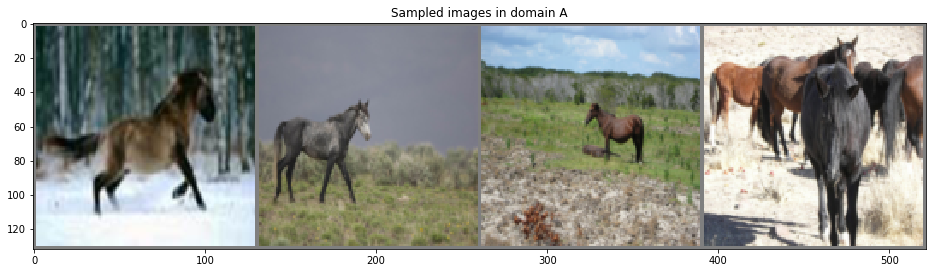

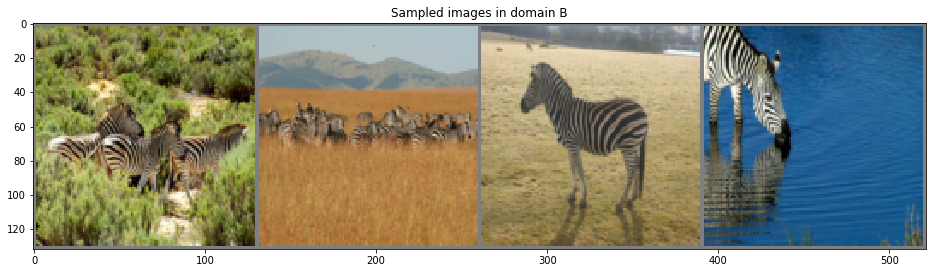

In [6]:
transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, test_loader = get_loaders(DATASET_NAME, transform, BATCH_SIZE, N_CPU)

images = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images["A"]), "Sampled images in domain A")
imshow(torchvision.utils.make_grid(images["B"]), "Sampled images in domain B")

## Model

![model](images/CycleGAN.png)

### Generator network

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ResBlock, self).__init__()
        self.pad = nn.ReflectionPad2d((kernel_size - 1) // 2)
        self.conv0 = nn.Conv2d(in_channels, 
                               out_channels, 
                               kernel_size, 
                               stride=stride, 
                               bias=False)
        self.norm0 = nn.InstanceNorm2d(out_channels)
        self.conv1 = nn.Conv2d(out_channels, 
                               out_channels, 
                               kernel_size, 
                               stride=stride, 
                               bias=False)
        self.norm1 = nn.InstanceNorm2d(out_channels)

    def forward(self, x):
        z = self.pad(x)
        z = self.conv0(z)
        z = self.norm0(z)
        z = F.relu(z, inplace=True)
        z = self.pad(z)
        z = self.conv1(z)
        z = self.norm1(z)
        return x + z

In [8]:
class Generator(nn.Module):
    def __init__(self, in_channel=3, out_channel=3):
        super(Generator, self).__init__()
        self.pad = nn.ReflectionPad2d(3)
        self.encoder = nn.Sequential(nn.Conv2d(in_channel, 64, 7, 1, bias=False),
                                     nn.InstanceNorm2d(64),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(64, 128, 3, 2, 1, bias=False),
                                     nn.InstanceNorm2d(128),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(128, 256, 3, 2, 1, bias=False),
                                     nn.InstanceNorm2d(256),
                                     nn.ReLU(inplace=True))
        self.transformer = nn.Sequential(ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1),
                                         ResBlock(256, 256, 3, 1))
        # TODO: switch from deconvolution to resize-convolution upsampling
        # to avoid checkerboard artifacts (https://distill.pub/2016/deconv-checkerboard/)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, 1, bias=False), 
                                     nn.ReLU(inplace=True),
                                     nn.InstanceNorm2d(128),
                                     nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
                                     nn.ReLU(inplace=True))
        self.output = nn.Sequential(nn.Conv2d(64, 3, 7, 1, bias=False), 
                                    nn.InstanceNorm2d(3),
                                    nn.Tanh())
        
    def forward(self, x):
        x = self.pad(x)
        x = self.encoder(x)
        x = self.transformer(x)
        x = self.decoder(x)
        x = self.pad(x)
        x = self.output(x)
        return x

output.shape = torch.Size([4, 3, 128, 128])


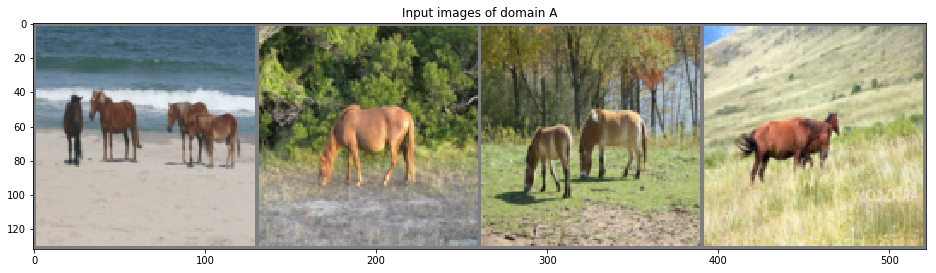

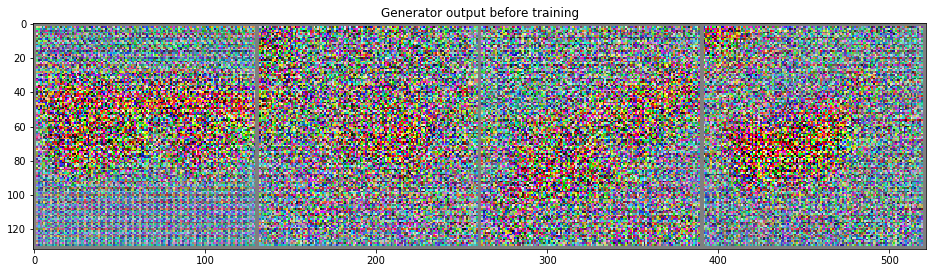

In [9]:
transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, test_loader = get_loaders(DATASET_NAME, transform, BATCH_SIZE, N_CPU)

images = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images["A"]), "Input images of domain A")

G = Generator()
output = G(images["A"])

imshow(torchvision.utils.make_grid(output), "Generator output before training")
print("output.shape =", output.shape)

### Discriminator network

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=3, out_channel=1):
        super(Discriminator, self).__init__()
        self.conv0 = nn.Conv2d(in_channel, 64, 4, 2, 1)
        self.conv1 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.norm1 = nn.InstanceNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.norm2 = nn.InstanceNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.norm3 = nn.InstanceNorm2d(512)
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv4 = nn.Conv2d(512, out_channel, 4, 1, 1)
        
    def forward(self, x):
        x = self.conv0(x)
        x = F.leaky_relu(x, inplace=True)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x, inplace=True)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x, inplace=True)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x, inplace=True)
        x = self.pad(x)
        x = self.conv4(x)
        return x

output.shape = torch.Size([4, 1, 8, 8])


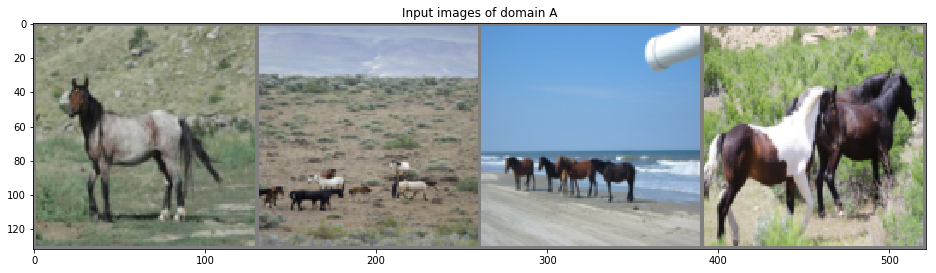

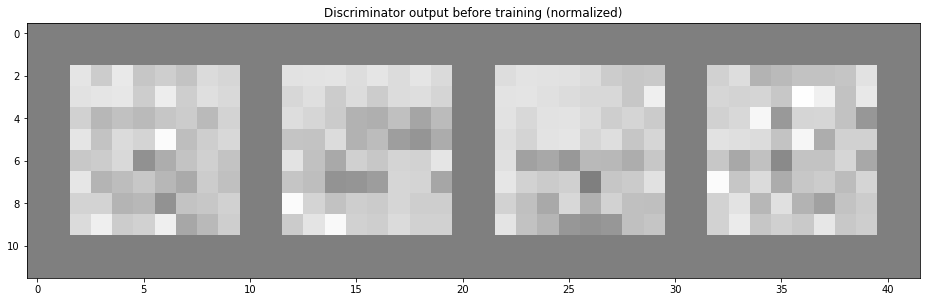

In [11]:
transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, test_loader = get_loaders(DATASET_NAME, transform, BATCH_SIZE, N_CPU)

images = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images["A"]), "Input images of domain A")

D = Discriminator()
output = D(images["A"])

# normalize the output to visualize it
imshow(torchvision.utils.make_grid(output, normalize=True), 
       "Discriminator output before training (normalized)")
print("output.shape =", output.shape)

### Losses

Two types of loss functions are used to train CycleGAN models: **adversarial losses** for matching the distribution of generated images to the data distribution in the target domain (since we're mapping $A$ to $B$ and $B$ to $A$, we need two adversarial loss functions for each generator function, $G_{AB}: A \rightarrow B$ and $G_{BA}: B \rightarrow A$); and **cycle consistency losses** to prevent the learned mappings between the two input domains from contradicting each other. The loss functions are expressed as follows,

$$\mathcal{L}_{GAN}(G_{AB}, D_B, A, B) = 
    \mathbb{E}_{b \sim p_{data(b)}} \big[ log D_B(b) \big] +
    \mathbb{E}_{a \sim p_{data(a)}} \big[ log(1 - D_B(G(a))) \big]$$

$$\mathcal{L}_{GAN}(G_{BA}, D_A, B, A) = 
    \mathbb{E}_{a \sim p_{data(a)}} \big[ log D_A(a) \big] +
    \mathbb{E}_{b \sim p_{data(b)}} \big[ log(1 - D_A(G(b))) \big]$$

$$\mathcal{L}_{cyc}(G_{AB}, G_{BA}) = 
    \mathbb{E}_{a \sim p_{data(a)}}
        \big[ {\left\lVert G_{BA}(G_{AB}(a)) - a \right\rVert}_1 \big] +
    \mathbb{E}_{b \sim p_{data(b)}}
        \big[ {\left\lVert G_{AB}(G_{BA}(b)) - b \right\rVert}_1 \big]$$

and finally,

$$\mathcal{L}(G_{AB}, G_{BA}, D_A, D_B) = 
    \mathcal{L}_{GAN}(G_{AB}, D_B, A, B)
    + \mathcal{L}_{GAN}(G_{BA}, D_A, B, A)
    + \lambda\mathcal{L}_{cyc}(G_{AB}, G_{BA})$$

Note that Zhu et al. state in training detail that using a **least-squares loss** instead of the negative log likelihood as originally defined improved stability during training and generates higher quality result. We'll try them ourselves and see the difference!

In [12]:
adv_loss = nn.MSELoss() # adversarial loss
cc_loss = nn.L1Loss() # cycle consistency loss

## Training

### Creating models

In [13]:
G_AB = Generator() # generator from domain A to domain B
G_BA = Generator() # generator from domain B to domain A
D_A = Discriminator() # discriminator for domain A
D_B = Discriminator() # discriminator for domain B

### CUDA

In [14]:
if torch.cuda.is_available():
    print("Training with CUDA!")
    device = torch.cuda.current_device()
    print("Device:", torch.cuda.get_device_name(device))
    
    G_AB = G_AB.cuda(device)
    G_BA = G_BA.cuda(device)
    D_A = D_A.cuda(device)
    D_B = D_B.cuda(device)
    
    adv_loss_mse = adv_loss.cuda(device)
    cc_loss = cc_loss.cuda(device)
    
    from torch.cuda import FloatTensor as Tensor

else:
    print("Training with CPUs!")
    from torch import Tensor

Training with CUDA!
Device: GeForce GTX 1060


### Optimizers

In [15]:
optimizer_G = Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), 
                   lr=ALPHA, betas=(BETA_1, BETA_2))
optimizer_D_A = Adam(D_A.parameters(), lr=ALPHA, betas=(BETA_1, BETA_2))
optimizer_D_B = Adam(D_B.parameters(), lr=ALPHA, betas=(BETA_1, BETA_2))

In [16]:
# we keep the same learning rate for the first 100 epochs and 
# linearly decay the rate to zero over the next 100 epochs (Zhu, et al.)
def lr_decay(n_epoch, decay_start):
    return lambda epoch: 1.0 - max(0.0, (epoch - decay_start) / (n_epoch - decay_start))

lr_lambda = lr_decay(N_EPOCH, EPOCH_DECAY)

lr_scheduler_G = LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

### Train step

In [17]:
def train_step(batch):
    # input shape is (batch_size, channels, height, width)
    real_A = Variable(batch["A"].type(Tensor))
    real_B = Variable(batch["B"].type(Tensor))

    patch = (1, int(HEIGHT / 2**4), int(WIDTH / 2**4)) # patch dimensions
    real = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
    fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)
    
    # train generators =================
    optimizer_G.zero_grad()

    fake_B = G_AB(real_A)
    recov_A = G_BA(fake_B)
    fake_A = G_BA(real_B)
    recov_B = G_AB(fake_A)
    
    loss_G = ((adv_loss(D_A(fake_A), real) + adv_loss(D_B(fake_B), real)) / 2 +
              LAMBDA * (cc_loss(recov_A, real_A) + cc_loss(recov_B, real_B)) / 2)

    loss_G.backward()
    optimizer_G.step()
    # ==================================

    # train discriminator A ============
    optimizer_D_A.zero_grad()

    loss_D_A = (adv_loss(D_A(real_A), real) +
                adv_loss(D_A(fake_A.detach()), fake))

    loss_D_A.backward()
    optimizer_D_A.step()
    # ==================================
    
    # train discriminator B ============
    optimizer_D_B.zero_grad()

    loss_D_B = (adv_loss(D_B(real_B), real) +
                adv_loss(D_B(fake_B.detach()), fake))

    loss_D_B.backward()
    optimizer_D_B.step()
    # ==================================

### Single batch test

In [18]:
batch = iter(train_loader).next()

for i in tqdm(range(200)):
    train_step(batch)
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
imshow(torchvision.utils.make_grid(batch["A"]), "Input images of domain A")
imshow(torchvision.utils.make_grid(G_AB(Variable(batch["A"].type(Tensor))).cpu()),
                                   "Translated to images in domain B")
imshow(torchvision.utils.make_grid(batch["B"]), "Input images of domain A")
imshow(torchvision.utils.make_grid(G_BA(Variable(batch["B"].type(Tensor))).cpu()), 
                                   "Translated to images in domain A")

NameError: name 'IntProgress' is not defined

### "Coffee break"

In [ ]:
for i in tqdm(range(N_EPOCH)):
    for i, batch in enumerate(train_loader):
        train_step(batch)
    lr_scheduler_G.step()
    lr_scheduler_D.step()

## Experiments

## Results

In [ ]:
def sample_images(test_loader, batches_done):
    raise NotImplementedError

## References

- https://arxiv.org/pdf/1703.10593.pdf (Orignal CycleGAN paper)
- https://arxiv.org/pdf/1603.08155v1.pdf (Perceptual losses and image transformation network)
- https://arxiv.org/pdf/1607.08022.pdf (Instance normalization)